In [130]:
import torch 
import torch.nn as nn

import numpy as np
import pandas as pd
import seaborn as sns
import sklearn as skl
import matplotlib as mpl
import scipy.stats as stats
import matplotlib.pyplot as plt

from os.path import join
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

plt.rcParams['font.sans-serif'] = ['Hiragino Sans GB']
plt.rcParams['axes.unicode_minus'] = False

pal_train = sns.color_palette("PuBuGn")
pal_train_rev = pal_train.as_hex()[::-1]
pal_train_darker = sns.color_palette("PuBuGn_d")
pal_train_darker_rev = pal_train_darker.as_hex()[::-1]

In [131]:
data_root = r'/Users/drew/Documents/MathModeling/MathModeling/APMCM24_cn/data'

train_path = join(data_root, 'train.csv')
test_path = join(data_root, 'test.csv')

train = pd.read_csv(train_path, index_col='id')
test = pd.read_csv(test_path, index_col='id')

initial_features = list(test.columns)[:-2]

train.head()

,季风强度,地形排水,河流管理,森林砍伐,城市化,气候变化,大坝质量,淤积,农业实践,侵蚀,...,排水系统,海岸脆弱性,滑坡,流域,基础设施恶化,人口得分,湿地损失,规划不足,政策因素,洪水概率
id,,,,,,,,,,,,,,,,,,,,,
0,5,8,5,8,6,4,4,3,3,4,...,5,3,3,5,4,7,5,7,3,0.445
1,6,7,4,4,8,8,3,5,4,6,...,7,2,0,3,5,3,3,4,3,0.450
2,6,5,6,7,3,7,1,5,4,5,...,7,3,7,5,6,8,2,3,3,0.530
3,3,4,6,5,4,8,4,7,6,8,...,2,4,7,4,4,6,5,7,5,0.535
4,5,3,2,6,4,4,3,3,3,3,...,2,2,6,6,4,1,2,3,5,0.415


# Problem 2

将附件 train.csv 中洪水发生的概率聚类成不同类别，分析具有高、中、低风险的洪水事件的指标特征。然后，选取合适的指标，计算不同指标的权重，建立发生洪水不同风险的预警评价模型，最后进行模型的灵敏度分析。

首先分析数据的可聚类性质，然后进行聚类分析。

In [132]:
X = train.洪水概率.values.reshape(-1, 1)

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

k = 3
kmeans = KMeans(
    n_clusters=k, 
    verbose=2, 
    random_state=114514
)

kmeans.fit(X_scaled)
predicted_labels = kmeans.labels_
cluster_centers = kmeans.cluster_centers_

Initialization complete
Iteration 0, inertia 3782.1353305756493.
Iteration 1, inertia 2853.3598580972953.
Iteration 2, inertia 2736.7202815727155.
Iteration 3, inertia 2700.178523402272.
Converged at iteration 3: strict convergence.


In [133]:
# silhouette_avg = silhouette_score(X_scaled, predicted_labels)
# print("k-means平均轮廓系数: ", silhouette_avg)

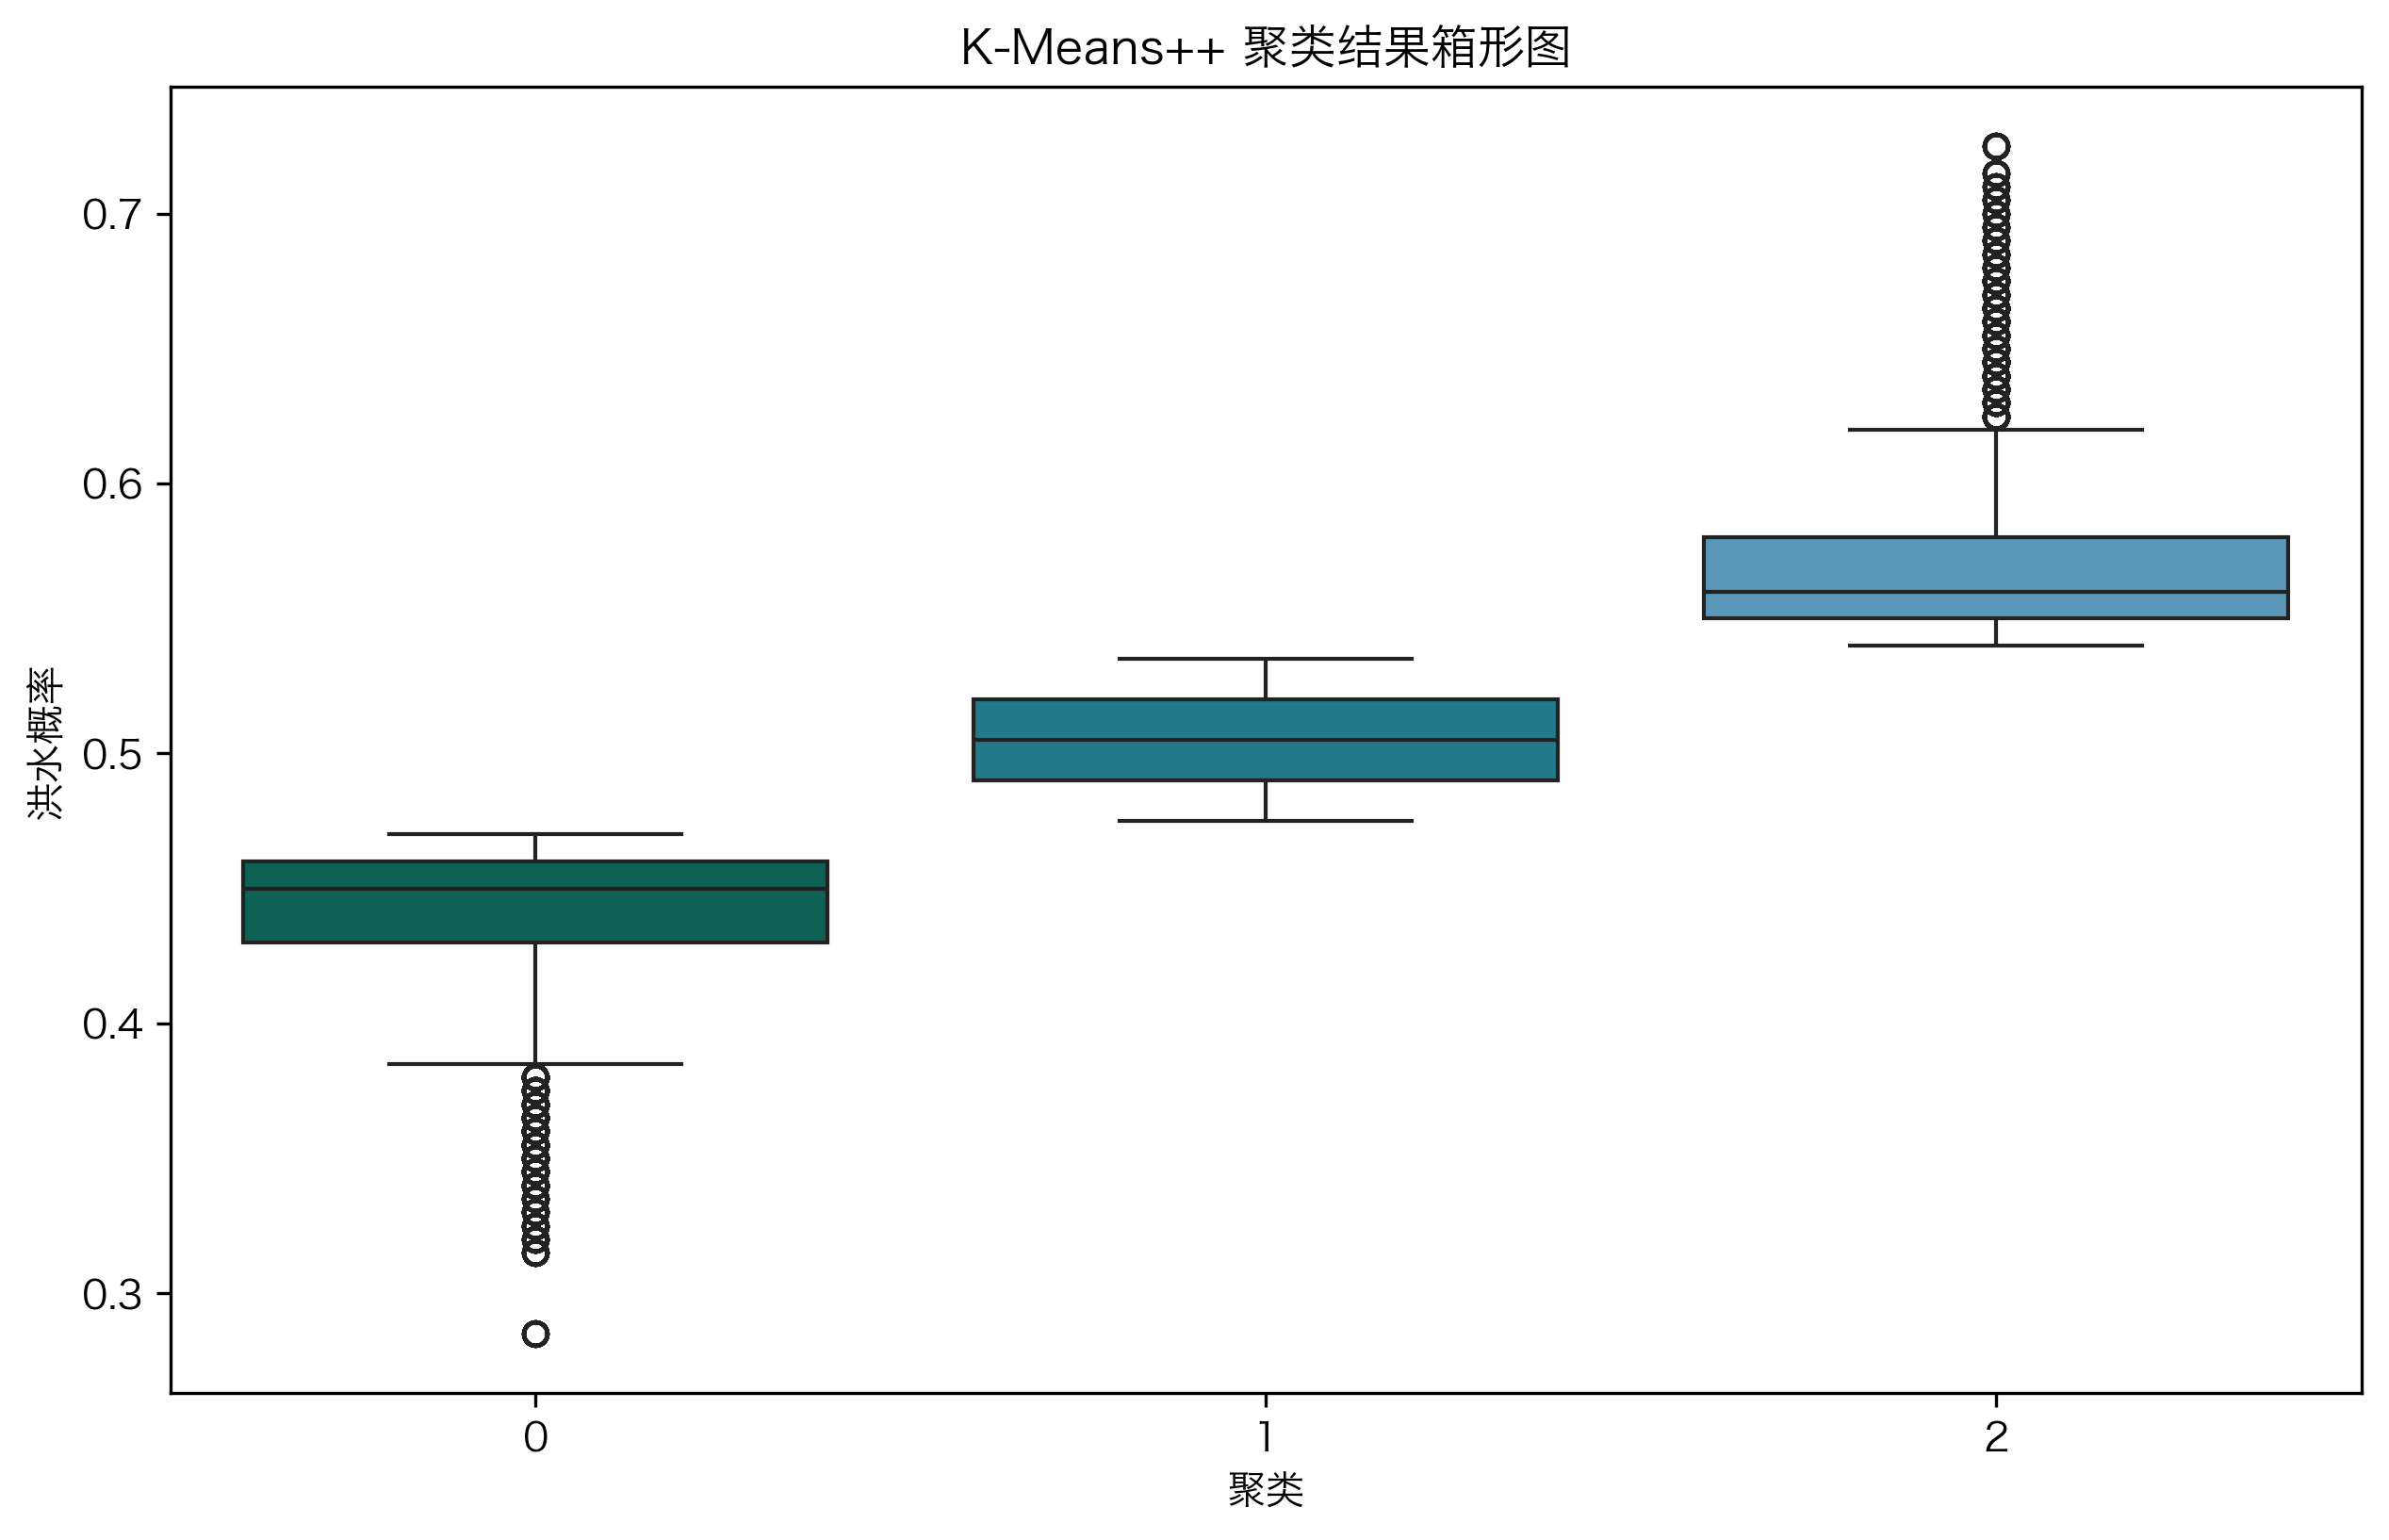

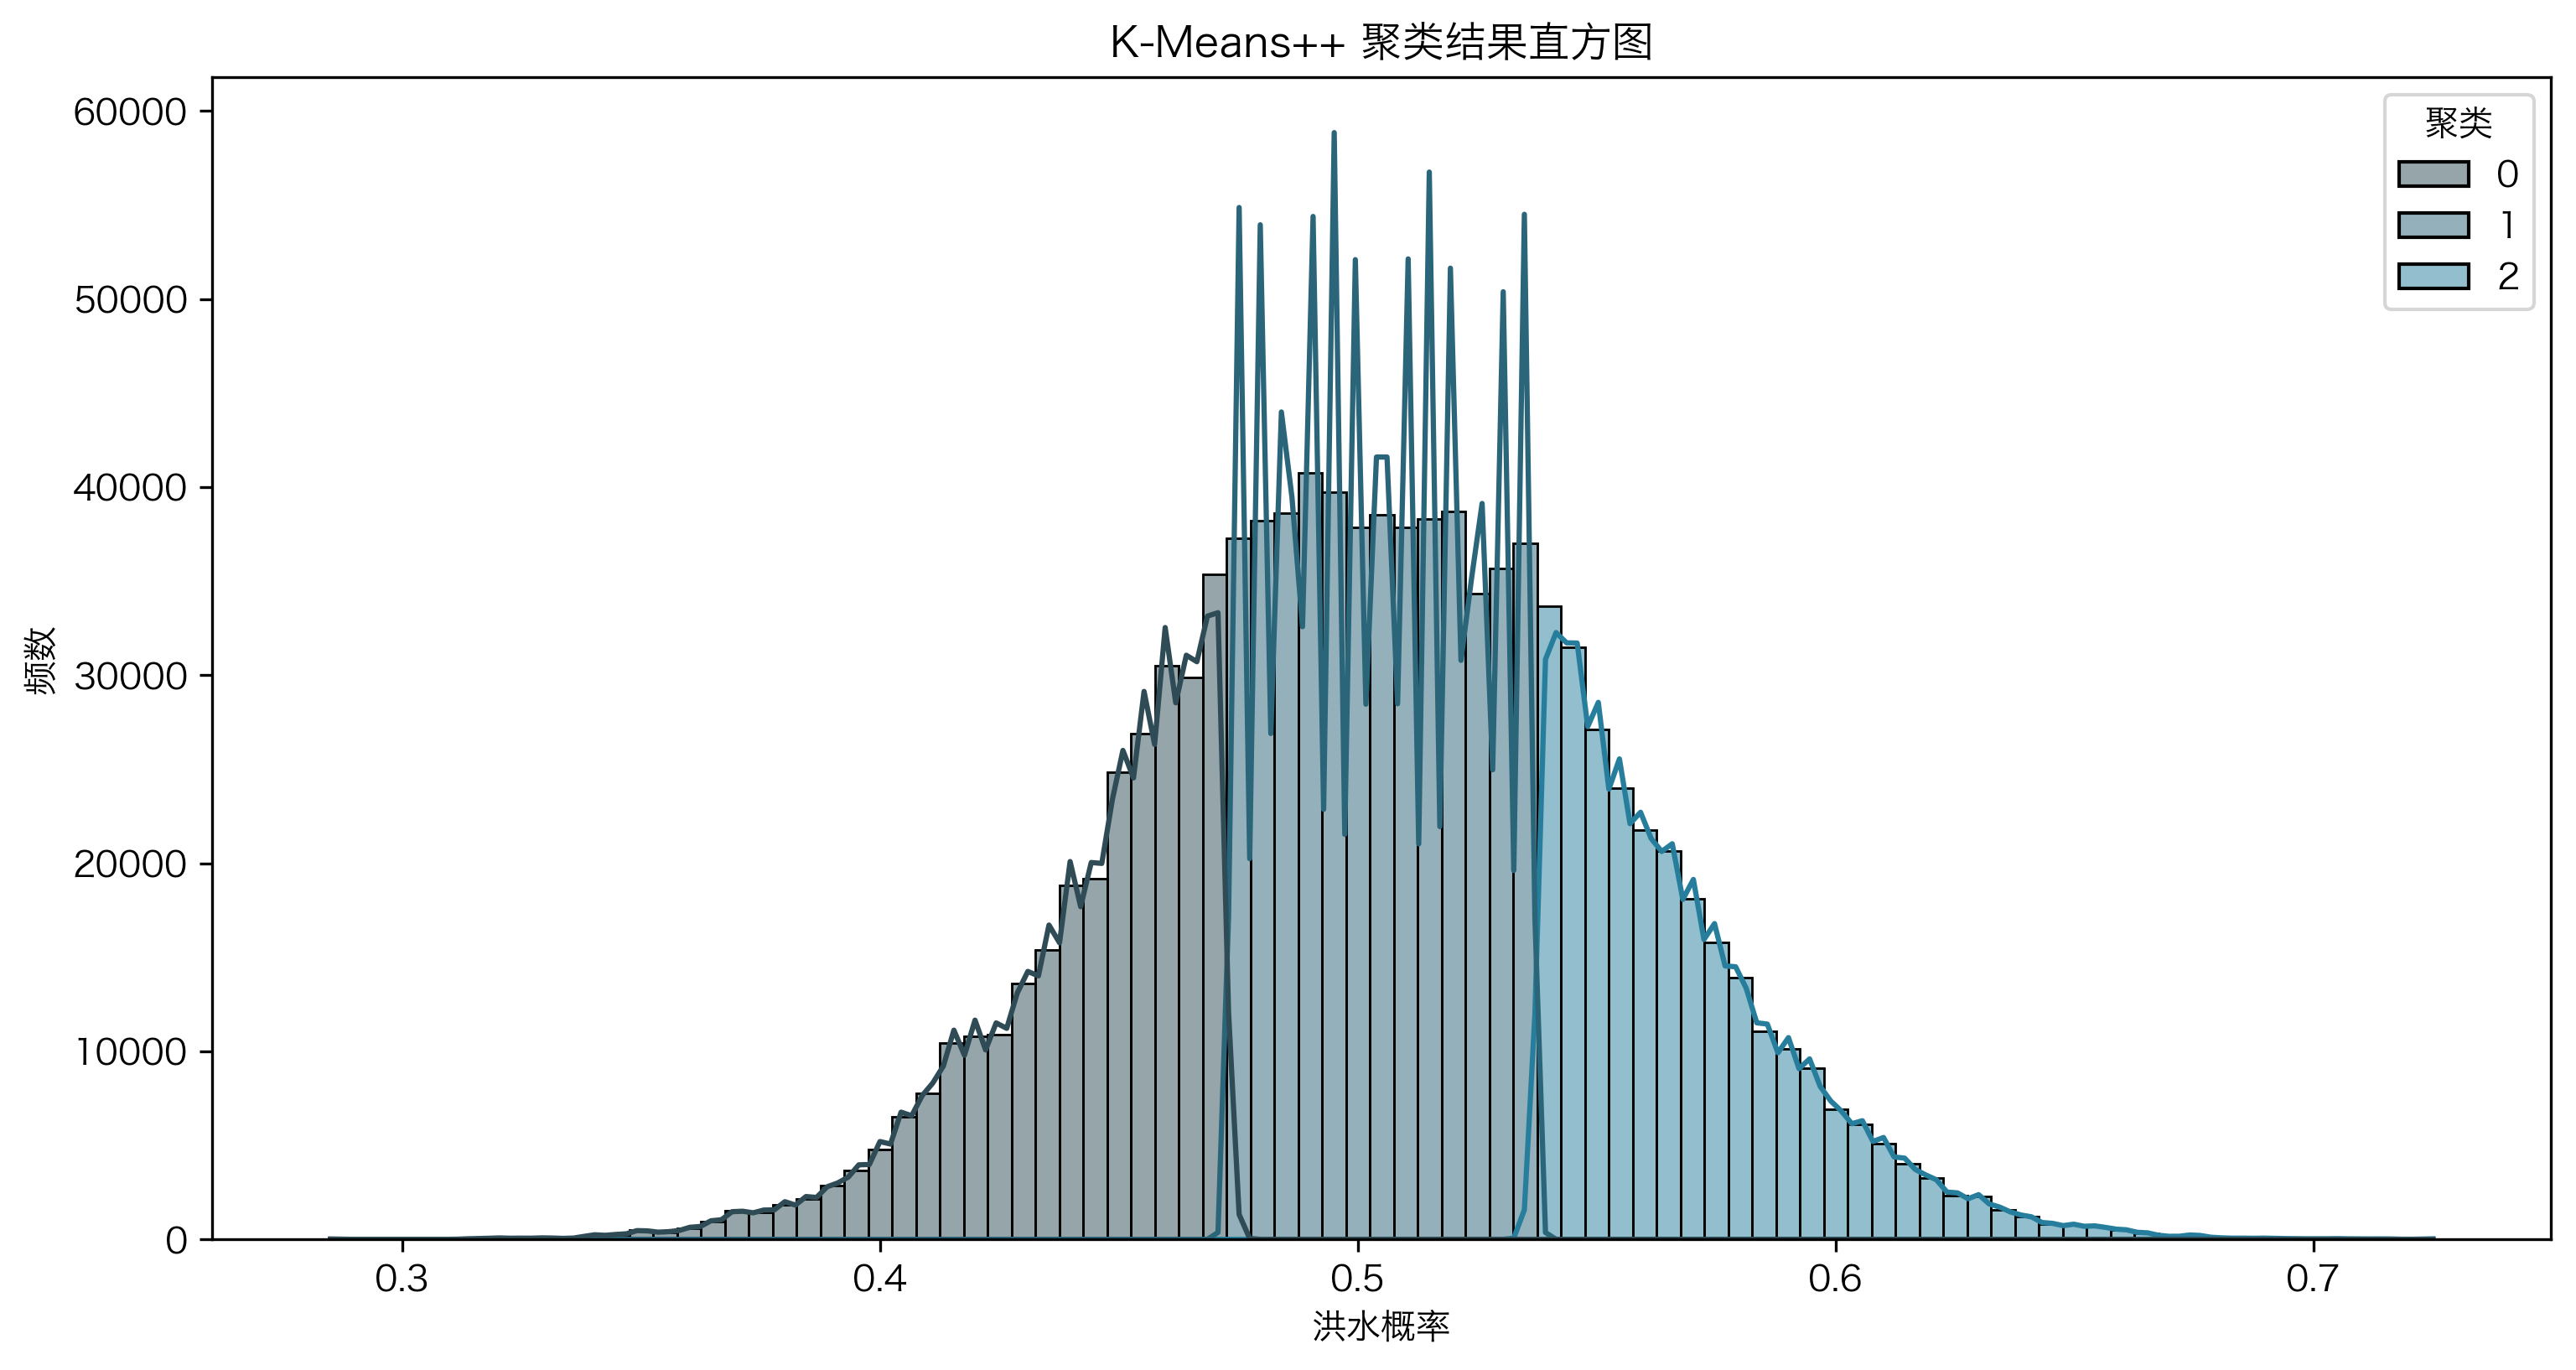

In [134]:
train['聚类'] = predicted_labels

plt.figure(figsize=(10, 6), dpi=300)
sns.boxplot(
    x='聚类', y='洪水概率', 
    data=train, 
    palette=pal_train_rev)
plt.title('K-Means++ 聚类结果箱形图')
plt.show()

plt.figure(figsize=(12, 6), dpi=300)
sns.histplot(
    data=train, 
    x='洪水概率', 
    hue='聚类', 
    bins=np.linspace(0.2825, 0.7275, 90),
    kde=True, 
    palette=pal_train_darker_rev)
plt.ylabel('频数')
plt.title('K-Means++ 聚类结果直方图')
plt.show()

In [135]:
train.head(10)

,季风强度,地形排水,河流管理,森林砍伐,城市化,气候变化,大坝质量,淤积,农业实践,侵蚀,...,海岸脆弱性,滑坡,流域,基础设施恶化,人口得分,湿地损失,规划不足,政策因素,洪水概率,聚类
id,,,,,,,,,,,,,,,,,,,,,
0,5,8,5,8,6,4,4,3,3,4,...,3,3,5,4,7,5,7,3,0.445,0
1,6,7,4,4,8,8,3,5,4,6,...,2,0,3,5,3,3,4,3,0.450,0
2,6,5,6,7,3,7,1,5,4,5,...,3,7,5,6,8,2,3,3,0.530,1
3,3,4,6,5,4,8,4,7,6,8,...,4,7,4,4,6,5,7,5,0.535,1
4,5,3,2,6,4,4,3,3,3,3,...,2,6,6,4,1,2,3,5,0.415,0
5,5,4,1,4,2,4,6,6,7,5,...,5,5,4,4,6,8,3,2,0.440,0
6,8,3,1,2,3,7,3,4,6,7,...,5,6,4,5,6,3,4,6,0.460,0
7,6,6,5,7,5,5,3,5,5,5,...,3,5,5,8,6,8,5,6,0.595,2
8,5,2,8,5,4,5,2,4,5,5,...,2,7,3,4,6,4,5,5,0.505,1


In [136]:
train.to_csv(join(data_root, 'train_cluster.csv'))

In [137]:
cls_df = train.groupby('聚类')
cls_0 = cls_df.get_group(0)
cls_1 = cls_df.get_group(1)
cls_2 = cls_df.get_group(2)

In [138]:
vals_des = [cls_x.describe().洪水概率 for cls_x in [cls_0, cls_1, cls_2]]
idxs = ['低风险', '中风险', '高风险']
stat_df = pd.DataFrame(vals_des, index=idxs)
stat_df.head()

,count,mean,std,min,25%,50%,75%,max
低风险,282202.0,0.442312,0.024768,0.285,0.43,0.450,0.46,0.470
中风险,492938.0,0.504591,0.018557,0.475,0.49,0.505,0.52,0.535
高风险,273435.0,0.568401,0.025650,0.540,0.55,0.560,0.58,0.725


可见，低风险、中风险和高风险的洪水事件概率分布是无交错的，故无需对获得的标签进行进一步处理。

然而，对于评估分类结果，我们仍旧需要进一步处理。

此处是回归任务，回归得出一个概率数值。然而，对于风险评级的划分，我们需要得出 [0,1] 区间内的三个子区间， 此时的分割为 [[0.285, 0.47], [0.475, 0.535], [0.54, 0.725]]，这些区间中间是有空缺的，如何填补这个空缺实现完整的一个回归区间划分从而实现回归+三分类模型的较优划分呢？

我们对train数据的洪水概率进行统计，基于其分布情况，进行区间填补。

In [139]:
fitting_set = train[['洪水概率', '聚类']]
fit_train_X, fit_test_X, fit_train_y, fit_test_y = train_test_split(
    fitting_set.洪水概率, fitting_set.聚类,
    train_size=0.9, test_size=0.1, 
    random_state=114514)

In [140]:
fit_train_X = fit_train_X.values.reshape(-1, 1)
fit_test_X = fit_test_X.values.reshape(-1, 1)

In [141]:
# l1_ratio = 0.5  # L1 weight in the Elastic-Net regularization

# # Set regularization parameter
# for i, C in enumerate((1, 0.1, 0.01)):
#     # Increase tolerance for short training time
#     clf_l1_LR = LogisticRegression(C=C, penalty="l1", tol=0.01, solver="saga")
#     clf_l2_LR = LogisticRegression(C=C, penalty="l2", tol=0.01, solver="saga")
#     clf_en_LR = LogisticRegression(
#         C=C, penalty="elasticnet", solver="saga", l1_ratio=l1_ratio, tol=0.01
#     )
#     clf_l1_LR.fit(fit_train_X, fit_train_y)
#     clf_l2_LR.fit(fit_train_X, fit_train_y)
#     clf_en_LR.fit(fit_train_X, fit_train_y)

#     coef_l1_LR = clf_l1_LR.coef_.ravel()
#     coef_l2_LR = clf_l2_LR.coef_.ravel()
#     coef_en_LR = clf_en_LR.coef_.ravel()

#     # coef_l1_LR contains zeros due to the
#     # L1 sparsity inducing norm

#     sparsity_l1_LR = np.mean(coef_l1_LR == 0) * 100
#     sparsity_l2_LR = np.mean(coef_l2_LR == 0) * 100
#     sparsity_en_LR = np.mean(coef_en_LR == 0) * 100

#     print(f"C={C:.2f}")
#     print(f"{'Sparsity with L1 penalty:':<40} {sparsity_l1_LR:.2f}%")
#     print(f"{'Sparsity with Elastic-Net penalty:':<40} {sparsity_en_LR:.2f}%")
#     print(f"{'Sparsity with L2 penalty:':<40} {sparsity_l2_LR:.2f}%")
#     print(f"{'Score with L1 penalty:':<40} {clf_l1_LR.score(fit_test_X, fit_test_y):.2f}")
#     print(f"{'Score with Elastic-Net penalty:':<40} {clf_en_LR.score(fit_test_X, fit_test_y):.2f}")
#     print(f"{'Score with L2 penalty:':<40} {clf_l2_LR.score(fit_test_X, fit_test_y):.2f}")

这是对逻辑回归模型在不同正则化参数 `C` 和不同正则化类型（L1、Elastic-Net、L2）下的性能评估。下面是对输出结果的解释：

1. **C 参数**:
   - `C` 是正则化强度的倒数。在这个案例中，`C` 的值从 1.00 逐渐减小到 0.01，随着 `C` 的减小，正则化强度增加。

2. **稀疏性（Sparsity）**:
   - 稀疏性是指模型系数中有多少比例是精确为零的。L1 正则化因其稀疏性而特别有用，因为它可以将不重要的特征系数压缩至零。然而，这里的输出显示所有三种正则化方法都没有产生稀疏模型（稀疏性为 0.00%），这意味着没有特征系数被压缩至零。

3. **准确率（Score）**:
   - 分数是模型在测试集上的准确度。对于 `C=1.00` 和 `C=0.10`，所有模型的准确度都是 1.00 或非常接近 1.00。当 `C` 减小到 0.01 时，L1 和 L2 正则化模型的准确度略有下降至 0.93，而 Elastic-Net 模型的准确度下降到 0.93（与 L2 相同）。

4. **正则化类型**:
   - L1 正则化（Lasso）：即使在 `C` 值较小的情况下，也没有产生稀疏模型，这可能表明所有特征都对模型的预测有贡献，或者模型可能需要更小的 `C` 值来观察到稀疏性。
   - Elastic-Net 正则化：随着 `C` 的减小，Elastic-Net 模型的准确度下降比 L1 和 L2 更显著，这可能是因为 Elastic-Net 结合了 L1 和 L2 正则化的特性，但在这个案例中没有产生稀疏性。
   - L2 正则化（Ridge）：即使在不同的 `C` 值下，L2 正则化模型的准确度保持不变，这与 L2 正则化不会将系数压缩至零的特性一致。

这些结果表明，在这些特定的参数设置下，模型可能没有遇到过拟合的问题，因此正则化没有导致特征系数变为零。然而，随着正则化强度的增加（`C` 值减小），模型的准确度有所下降，这可能是由于模型复杂度的降低。

在实践中，选择最佳的 `C` 值和正则化类型通常需要通过交叉验证等模型选择方法来确定，以找到在防止过拟合和保持模型准确度之间最佳的平衡点。

In [142]:
l1_ratio = 0.5  # L1 weight in the Elastic-Net regularization
C=1
clf_l1_LR = LogisticRegression(C=C, penalty="l1", tol=0.01, solver="saga", verbose=1)
clf_l1_LR.fit(fit_train_X, fit_train_y)

Epoch 1, change: 1.00000000
Epoch 2, change: 0.13296992
Epoch 3, change: 0.07611485
Epoch 4, change: 0.05675033
Epoch 5, change: 0.04746505
Epoch 6, change: 0.04070294
Epoch 7, change: 0.03644249
Epoch 8, change: 0.03270253
Epoch 9, change: 0.02974063
Epoch 10, change: 0.02728120
Epoch 11, change: 0.02511257
Epoch 12, change: 0.02326992
Epoch 13, change: 0.02164328
Epoch 14, change: 0.02024908
Epoch 15, change: 0.01894792
Epoch 16, change: 0.01785807
Epoch 17, change: 0.01683868
Epoch 18, change: 0.01591871
Epoch 19, change: 0.01508403
Epoch 20, change: 0.01434237
Epoch 21, change: 0.01365151
Epoch 22, change: 0.01301259
Epoch 23, change: 0.01242384
Epoch 24, change: 0.01189069
Epoch 25, change: 0.01139873
Epoch 26, change: 0.01092729
Epoch 27, change: 0.01050656
Epoch 28, change: 0.01009899
convergence after 29 epochs took 5 seconds


LogisticRegression(C=1, penalty='l1', solver='saga', tol=0.01, verbose=1)

In [143]:
coef_l1_LR = clf_l1_LR.coef_.ravel()
sparsity_l1_LR = np.mean(coef_l1_LR == 0) * 100
print(f"C={C:.2f}")
print(f"{'Sparsity with L1 penalty:':<40} {sparsity_l1_LR:.2f}%")
print(f"{'Score with L1 penalty:':<40} {clf_l1_LR.score(fit_test_X, fit_test_y):.2f}")

C=1.00
Sparsity with L1 penalty:                0.00%
Score with L1 penalty:                   1.00


In [144]:
len(train), len(test)

(1048575, 745305)

In [145]:
sample = np.linspace(0.2825, 0.7275, 100*1048575).reshape(-1, 1)
detailed = clf_l1_LR.predict(sample)
pred_df = pd.DataFrame({
    '样本': sample.squeeze(),
    '分类': detailed
})
pred_df.head()

,样本,分类
0,0.2825,0
1,0.2825,0
2,0.2825,0
3,0.2825,0
4,0.2825,0


In [146]:
grp_pred = pred_df.groupby('分类')
grp_0 = grp_pred.get_group(0)
grp_1 = grp_pred.get_group(1)
grp_2 = grp_pred.get_group(2)

In [147]:
preds_des = [grp_x.describe().样本 for grp_x in [grp_0, grp_1, grp_2]]
idxs = ['低风险', '中风险', '高风险']
p_stat_df = pd.DataFrame(preds_des, index=idxs)
p_stat_df.head()

,count,mean,std,min,25%,50%,75%,max
低风险,44765752.0,0.377490,0.054842,0.282500,0.329995,0.377490,0.424985,0.472479
中风险,15330807.0,0.505010,0.018782,0.472479,0.488745,0.505010,0.521276,0.537541
高风险,44760941.0,0.632521,0.054836,0.537541,0.585031,0.632521,0.680010,0.727500


In [148]:
low = [0, p_stat_df['max'].loc['低风险']]
mid = [p_stat_df['min'].loc['中风险'], p_stat_df['max'].loc['中风险']]
high = [p_stat_df['min'].loc['高风险'], 1]
low, mid, high

([0, 0.47247934706605965],
 [0.4724793513099144, 0.5375410658755079],
 [0.5375410701193627, 1])

此时找到两个基本连续的区间

[0.282500, 0.472481], [0.472481, 0.537549], [0.537549, 0.727500]

原始: [0.285, 0.47], [0.475, 0.535], [0.54, 0.725]

因此，得出区间划分的结论为：

- 低风险区间：[0, 0.4724814817250219]
- 中风险区间：[0.4724814859688767, 0.5375491376873294]
- 高风险区间：[0.5375491419311842, 1]

此时，区间之间的差异很小，基本视为连续。可直接取平均数为分割点而不对结果产生影响

In [149]:
l_m_sep = (p_stat_df['max'].loc['低风险'] + p_stat_df['min'].loc['中风险']) / 2
m_h_sep = (p_stat_df['max'].loc['中风险'] + p_stat_df['min'].loc['高风险']) / 2
low  = [0, l_m_sep]
mid  = [l_m_sep, m_h_sep]
high = [m_h_sep, 1]
low, mid, high

([0, 0.47247934918798706],
 [0.47247934918798706, 0.5375410679974353],
 [0.5375410679974353, 1])

In [150]:
cls_0.describe()

,季风强度,地形排水,河流管理,森林砍伐,城市化,气候变化,大坝质量,淤积,农业实践,侵蚀,...,海岸脆弱性,滑坡,流域,基础设施恶化,人口得分,湿地损失,规划不足,政策因素,洪水概率,聚类
count,282202.000000,282202.000000,282202.000000,282202.000000,282202.000000,282202.000000,282202.000000,282202.000000,282202.000000,282202.000000,...,282202.000000,282202.000000,282202.000000,282202.000000,282202.000000,282202.000000,282202.000000,282202.000000,282202.000000,282202.0
mean,4.489334,4.473912,4.517686,4.513926,4.520205,4.511265,4.517059,4.491226,4.518388,4.517250,...,4.535294,4.495532,4.491162,4.492286,4.489855,4.523065,4.511828,4.512714,0.442312,0.0
std,1.971056,2.018529,2.002414,1.979408,2.005537,1.985112,2.003509,1.990504,1.999955,2.007968,...,2.017860,2.004089,2.006416,1.986694,1.994885,1.991615,2.011793,2.018284,0.024768,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.285000,0.0
25%,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,0.430000,0.0
50%,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,...,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,0.450000,0.0
75%,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,...,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,0.460000,0.0
max,16.000000,18.000000,16.000000,16.000000,16.000000,17.000000,16.000000,16.000000,16.000000,17.000000,...,17.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,0.470000,0.0


In [151]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from colorama import Fore, Style
import xgboost
import lightgbm
import catboost
import os
import datetime
import pickle
import warnings
import umap
import statsmodels.api as sm

from sklearn.base import clone
from sklearn.model_selection import KFold, StratifiedKFold 
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, SplineTransformer, OneHotEncoder
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.manifold import TSNE
from sklearn.compose import TransformedTargetRegressor

In [152]:
# Configuration
# Produce a submission file (you can set this to false if you only
# want to see the cross-validation results)
COMPUTE_TEST_PRED = True

# Containers for results
oof, test_pred = {}, {}

In [202]:
kf = KFold(n_splits=5, shuffle=True, random_state=1)

SINGLE_FOLD = True

weight_dir = '/Users/drew/Documents/MathModeling/MathModeling/APMCM24_cn/weights'

from joblib import dump

def _classify(O_reg, label_cls, low, mid, high):
    cnt = 0
    for _, (o_reg, l_cls) in enumerate(zip(O_reg, label_cls)):
        o_cls = None
        if o_reg < low[1]:
            o_cls = 0
        elif o_reg >= mid[0] and o_reg < mid[1]:
            o_cls = 1
        elif o_reg >= high[0] and o_reg <= high[1]:
            o_cls = 2
        if o_cls == l_cls:
            cnt += 1
    return cnt

def cross_validate(model, label, features=initial_features, n_repeats=1):
    """Compute out-of-fold and test predictions for a given model.
    
    Out-of-fold and test predictions are stored in the global variables
    oof and test_pred, respectively.
    
    If n_repeats > 1, the model is trained several times with different seeds.
    """
    best_model = None
    best_score = float('-inf')
    
    start_time = datetime.datetime.now()
    scores = []
    oof_preds = np.full_like(train.洪水概率, np.nan, dtype=float)
    cls_cnt, sample_num = 0, 0
    for fold, (idx_tr, idx_va) in enumerate(kf.split(train)):
        X_train = train.iloc[idx_tr][features]
        X_val = train.iloc[idx_va][features]
        y_train = train.iloc[idx_tr].洪水概率
        y_val = train.iloc[idx_va].洪水概率
        y_label = train.iloc[idx_va].聚类
        
        y_pred = np.zeros_like(y_val, dtype=float)
        for i in range(n_repeats):
            m = clone(model)
            if n_repeats > 1:
                mm = m
                if isinstance(mm, Pipeline):
                    mm = mm[-1]
                mm.set_params(random_state=i)
            m.fit(X_train, y_train)
            dump(m, os.path.join(weight_dir, f'{label}_{fold}_{i}.joblib'))
            y_pred += m.predict(X_val)
        y_pred /= n_repeats
        sample_num += len(y_label)
        
        cls_cnt += _classify(y_pred, y_label, low, mid, high)
        acc_3 = cls_cnt / sample_num
        score = r2_score(y_val, y_pred)
        print(f"# Fold {fold}: R2={score:.5f}, acc_3={acc_3:.5f}")
        
        if score > best_score:
            best_score = score
            best_model = clone(m)  # 克隆当前模型实例
        
        scores.append(score)
        oof_preds[idx_va] = y_pred
        if SINGLE_FOLD: break
                    
    elapsed_time = datetime.datetime.now() - start_time
    print(f"{Fore.GREEN}# Overall: {np.array(scores).mean():.5f} {label}"
          f"{' single fold' if SINGLE_FOLD else ''}"
          f"   {int(np.round(elapsed_time.total_seconds() / 60))} min{Style.RESET_ALL}")
    oof[label] = oof_preds
    
    if COMPUTE_TEST_PRED:
        # Retrain n_repeats times with the whole dataset and average
        y_pred = np.zeros(len(test), dtype=float)
        X_train = train[features]
        y_train = train.洪水概率
        for i in range(n_repeats):
            m = clone(model)
            if n_repeats > 1:
                mm = m
                if isinstance(mm, Pipeline):
                    mm = mm[-1]
                if isinstance(mm, TransformedTargetRegressor):
                    mm = mm.regressor
                mm.set_params(random_state=i)
            m.fit(X_train, y_train)
            y_pred += m.predict(test[features])
        y_pred /= n_repeats
        test_pred[label] = y_pred
    
    return best_model

In [154]:
X = sm.add_constant(train[initial_features])
res = sm.OLS(train.洪水概率, X, missing='error').fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   洪水概率   R-squared:                       0.792
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                 2.097e+05
Date:                Fri, 05 Jul 2024   Prob (F-statistic):               0.00
Time:                        21:07:06   Log-Likelihood:             2.4543e+06
No. Observations:             1048575   AIC:                        -4.909e+06
Df Residuals:                 1048555   BIC:                        -4.908e+06
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0181      0.000    -68.708      0.000      -0.019      -0.018
季风强度           0.0056   1.11e-05    501.301      0.000       0.006       0.006
地形排水           0.0056   1.09e-05    511.051      0.000       0.006       0.006
河流管理           0.0056    1.1e-05    508.217      0.000       0.006       0.006
森林砍伐           0.0056   1.11e-05    505.483      0.000       0.006       0.006
城市化            0.0056   1.09e-05    508.843      0.000       0.006       0.006
气候变化           0.0056   1.11e-05    504.619      0.000       0.006       0.006
大坝质量           0.0056   1.09e-05    509.158      0.000       0.006       0.006
淤积             0.0056    1.1e-05    506.151      0.000       0.006       0.006
农业实践           0.0056    1.1e-05    504.647      0.000       0.006       0.006
侵蚀             0.0056   1.09e-05    508.610      0.000       0.006       0.006
无效防灾           0.0056    1.1e-05    507.661      0.000       0.006       0.006
排水系统           0.0056    1.1e-05    504.972      0.000       0.006       0.006
海岸脆弱性          0.0056   1.09e-05    511.475      0.000       0.006       0.006
滑坡             0.0056    1.1e-05    508.069      0.000       0.006       0.006
流域             0.0056   1.09e-05    508.996      0.000       0.006       0.006
基础设施恶化         0.0056    1.1e-05    503.786      0.000       0.006       0.006
人口得分           0.0056    1.1e-05    509.383      0.000       0.006       0.006
湿地损失           0.0056    1.1e-05    504.759      0.000       0.006       0.006
规划不足           0.0055   1.09e-05    505.251      0.000       0.006       0.006
==============================================================================
Omnibus:                    31678.309   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            36206.664
Skew:                           0.402   Prob(JB):                         0.00
Kurtosis:                       3.428   Cond. No.                         250.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

根据您提供的普通最小二乘法（OLS）回归分析结果，我们可以对模型进行以下分析：

1. **模型概述**：
   - 因变量（Dep. Variable）是“洪水概率”，即预测洪水发生的概率。
   - R-squared（决定系数）为0.792，表明模型解释了79.2%的变量变异性，这是一个相对较高的值，说明模型拟合效果较好。
   - Adj. R-squared（调整后的决定系数）也为0.792，这表明即使在添加了多个解释变量后，模型的解释能力仍然很高。

2. **模型统计检验**：
   - F-statistic（F统计量）为2.097e+05，这是一个非常高的值，表明模型中至少有一个解释变量对因变量有显著影响。
   - Prob (F-statistic)（F统计量的P值）为0.00，远小于0.05，表明模型在统计上是显著的。

3. **模型拟合优度**：
   - Log-Likelihood（对数似然函数）为2.4543e+06，用于模型比较。
   - AIC（赤池信息准则）和BIC（贝叶斯信息准则）分别为-4.909e+06和-4.908e+06，这两个值通常用于模型选择，值越低表示模型拟合得越好。

4. **模型参数估计**：
   - 回归系数（coef）显示了每个解释变量对“洪水概率”的影响大小。所有特征的系数都非常接近0.0056，这表明每个特征的增加都会使洪水概率增加0.56%（在保持其他变量不变的情况下）。
   - 标准误差（std err）非常小，表明估计的系数非常精确。
   - t统计量（t）和P>|t|（t统计量的P值）都表明所有特征在统计上都是显著的。

5. **模型诊断**：
   - Omnibus（总体检验）和Prob(Omnibus)（总体检验的P值）用于检测残差的正态性，这里的P值为0.000，表明残差可能不服从正态分布。
   - Durbin-Watson（德宾-沃森检验）值为2.001，接近2，表明没有自相关性。
   - Jarque-Bera (JB)（贾奎-贝拉检验）的P值为0.00，表明残差的分布可能偏离正态分布。
   - Skewness（偏度）为0.402，Kurtosis（峰度）为3.428，这些值表明残差分布可能不对称，并且有厚尾。

6. **模型稳健性**：
   - Covariance Type（协方差类型）为nonrobust，表明模型的系数估计可能对异常值敏感。

7. **条件数**：
   - Cond. No.（条件数）为250，这个值相对较低，表明模型没有严重的多重共线性问题。

综上所述，您的OLS回归模型在统计上是显著的，拟合效果较好，但残差的分布可能不完全符合正态分布的假设。在实际应用中，可能需要进一步的模型诊断和改进。

所有特征的系数基本相同，都是0.0056。我们可以用散文的形式解释这个模型：

> **将所有特征的总和乘以0.0056，再减去0.05，你就可以得到洪水发生的概率。**

我们可以用一行代码实现这一点，并得到0.844的R平方分数：

> **"将所有特征的总和乘以0.0056，然后减去0.05，就可以得到洪水发生的概率。"** 在这里，R平方分数（R-squared score）0.844表明该模型能解释洪水概率变异的84.4%。


In [155]:
X_0 = sm.add_constant(cls_0[initial_features])
res_0 = sm.OLS(cls_0.洪水概率, X_0, missing='error').fit()
res_0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   洪水概率   R-squared:                       0.634
Model:                            OLS   Adj. R-squared:                  0.634
Method:                 Least Squares   F-statistic:                 2.578e+04
Date:                Fri, 05 Jul 2024   Prob (F-statistic):               0.00
Time:                        21:07:06   Log-Likelihood:             7.8522e+05
No. Observations:              282202   AIC:                        -1.570e+06
Df Residuals:                  282182   BIC:                        -1.570e+06
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1427      0.000    332.647      0.000       0.142       0.144
季风强度           0.0035   1.46e-05    238.804      0.000       0.003       0.004
地形排水           0.0035   1.43e-05    246.146      0.000       0.003       0.004
河流管理           0.0035   1.44e-05    243.361      0.000       0.003       0.004
森林砍伐           0.0035   1.46e-05    240.532      0.000       0.003       0.004
城市化            0.0035   1.44e-05    242.875      0.000       0.003       0.004
气候变化           0.0035   1.45e-05    240.883      0.000       0.003       0.004
大坝质量           0.0035   1.44e-05    241.805      0.000       0.003       0.004
淤积             0.0035   1.45e-05    243.071      0.000       0.003       0.004
农业实践           0.0035   1.44e-05    242.756      0.000       0.003       0.004
侵蚀             0.0035   1.43e-05    244.735      0.000       0.003       0.004
无效防灾           0.0035   1.44e-05    242.993      0.000       0.003       0.004
排水系统           0.0035   1.44e-05    242.450      0.000       0.003       0.004
海岸脆弱性          0.0035   1.43e-05    243.637      0.000       0.003       0.004
滑坡             0.0035   1.44e-05    243.277      0.000       0.003       0.004
流域             0.0035   1.43e-05    244.228      0.000       0.003       0.004
基础设施恶化         0.0035   1.45e-05    241.128      0.000       0.003       0.004
人口得分           0.0035   1.44e-05    243.721      0.000       0.003       0.004
湿地损失           0.0035   1.45e-05    242.073      0.000       0.003       0.004
规划不足           0.0035   1.43e-05    245.737      0.000       0.003       0.004
==============================================================================
Omnibus:                     6097.945   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9879.220
Skew:                          -0.210   Prob(JB):                         0.00
Kurtosis:                       3.814   Cond. No.                         300.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [156]:
X_1 = sm.add_constant(cls_1[initial_features])
res_1 = sm.OLS(cls_1.洪水概率, X_1, missing='error').fit()
res_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   洪水概率   R-squared:                       0.240
Model:                            OLS   Adj. R-squared:                  0.240
Method:                 Least Squares   F-statistic:                     8201.
Date:                Fri, 05 Jul 2024   Prob (F-statistic):               0.00
Time:                        21:07:07   Log-Likelihood:             1.3336e+06
No. Observations:              492938   AIC:                        -2.667e+06
Df Residuals:                  492918   BIC:                        -2.667e+06
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3076      0.000    615.604      0.000       0.307       0.309
季风强度           0.0021   1.21e-05    171.977      0.000       0.002       0.002
地形排水           0.0021   1.19e-05    179.535      0.000       0.002       0.002
河流管理           0.0021    1.2e-05    175.331      0.000       0.002       0.002
森林砍伐           0.0021   1.21e-05    175.727      0.000       0.002       0.002
城市化            0.0021   1.19e-05    177.810      0.000       0.002       0.002
气候变化           0.0021   1.21e-05    176.616      0.000       0.002       0.002
大坝质量           0.0021   1.19e-05    177.521      0.000       0.002       0.002
淤积             0.0021    1.2e-05    175.673      0.000       0.002       0.002
农业实践           0.0021    1.2e-05    176.099      0.000       0.002       0.002
侵蚀             0.0021   1.19e-05    175.546      0.000       0.002       0.002
无效防灾           0.0021   1.19e-05    177.709      0.000       0.002       0.002
排水系统           0.0021    1.2e-05    173.686      0.000       0.002       0.002
海岸脆弱性          0.0021   1.19e-05    176.864      0.000       0.002       0.002
滑坡             0.0021   1.19e-05    176.685      0.000       0.002       0.002
流域             0.0021   1.19e-05    178.172      0.000       0.002       0.002
基础设施恶化         0.0021    1.2e-05    175.659      0.000       0.002       0.002
人口得分           0.0021    1.2e-05    176.967      0.000       0.002       0.002
湿地损失           0.0021    1.2e-05    174.772      0.000       0.002       0.002
规划不足           0.0021   1.19e-05    176.491      0.000       0.002       0.002
==============================================================================
Omnibus:                    95043.650   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            20652.599
Skew:                          -0.139   Prob(JB):                         0.00
Kurtosis:                       2.036   Cond. No.                         466.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [157]:
X_2 = sm.add_constant(cls_2[initial_features])
res_2 = sm.OLS(cls_2.洪水概率, X_2, missing='error').fit()
res_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   洪水概率   R-squared:                       0.587
Model:                            OLS   Adj. R-squared:                  0.587
Method:                 Least Squares   F-statistic:                 2.049e+04
Date:                Fri, 05 Jul 2024   Prob (F-statistic):               0.00
Time:                        21:07:08   Log-Likelihood:             7.3472e+05
No. Observations:              273435   AIC:                        -1.469e+06
Df Residuals:                  273415   BIC:                        -1.469e+06
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2051      0.001    351.508      0.000       0.204       0.206
季风强度           0.0035   1.55e-05    228.201      0.000       0.004       0.004
地形排水           0.0035   1.54e-05    225.290      0.000       0.003       0.004
河流管理           0.0035   1.56e-05    227.876      0.000       0.004       0.004
森林砍伐           0.0035   1.56e-05    226.300      0.000       0.004       0.004
城市化            0.0035   1.54e-05    228.683      0.000       0.003       0.004
气候变化           0.0035   1.56e-05    226.184      0.000       0.003       0.004
大坝质量           0.0035   1.54e-05    228.686      0.000       0.003       0.004
淤积             0.0036   1.56e-05    227.757      0.000       0.004       0.004
农业实践           0.0035   1.56e-05    227.615      0.000       0.004       0.004
侵蚀             0.0035   1.55e-05    224.575      0.000       0.003       0.004
无效防灾           0.0035   1.56e-05    224.097      0.000       0.003       0.004
排水系统           0.0035   1.55e-05    227.425      0.000       0.003       0.004
海岸脆弱性          0.0035   1.54e-05    227.559      0.000       0.003       0.004
滑坡             0.0035   1.55e-05    228.482      0.000       0.004       0.004
流域             0.0035   1.55e-05    223.118      0.000       0.003       0.003
基础设施恶化         0.0035   1.55e-05    228.041      0.000       0.004       0.004
人口得分           0.0035   1.55e-05    229.073      0.000       0.004       0.004
湿地损失           0.0035   1.55e-05    227.656      0.000       0.004       0.004
规划不足           0.0035   1.55e-05    224.799      0.000       0.003       0.004
==============================================================================
Omnibus:                    39475.589   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            86335.159
Skew:                           0.865   Prob(JB):                         0.00
Kurtosis:                       5.142   Cond. No.                         440.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [158]:
r2_tr = r2_score(train.洪水概率, (train[initial_features].sum(axis=1) * 0.0056) - 0.0181)
r2_0 = r2_score(cls_0.洪水概率, (cls_0[initial_features].sum(axis=1) * 0.0035) + 0.1427)
r2_1 = r2_score(cls_1.洪水概率, (cls_1[initial_features].sum(axis=1) * 0.0021) + 0.3076)
r2_2 = r2_score(cls_2.洪水概率, (cls_2[initial_features].sum(axis=1) * 0.0035) + 0.2051)
r2_tr, r2_0, r2_1, r2_2

(0.7881980547513081,
 0.6344246328339683,
 0.23748252562114724,
 0.5808300995204012)

基准XGBoost

In [159]:
# XGBoost
xgb_params = {'grow_policy': 'depthwise', 'n_estimators': 100, 'learning_rate': 0.2639887908316703, 'max_depth': 10, 'reg_lambda': 62.46661785864016, 'min_child_weight': 0.33652299514909034, 'colsample_bytree': 0.2319730052165745, 'objective': 'reg:squarederror', 'tree_method': 'hist', 'max_bin': 2048, 'gamma': 0} # 0.83868
model = xgboost.XGBRegressor(**xgb_params)
cross_validate(model, 'XGBoost')
# Overall: 0.83949 XGB single fold   0 min

# Fold 0: R2=0.78723, acc_3=0.73249
# Overall: 0.78723 XGBoost single fold   0 min


基准CatBoost模型

In [160]:
model = catboost.CatBoostRegressor(verbose=False)
cross_validate(model, 'CatBoost')
# Overall: 0.84722 CB single fold   1 min

# Fold 0: R2=0.79424, acc_3=0.73736
# Overall: 0.79424 CatBoost single fold   1 min


基准模型的性能并不尽如人意，对数据进行深入观察

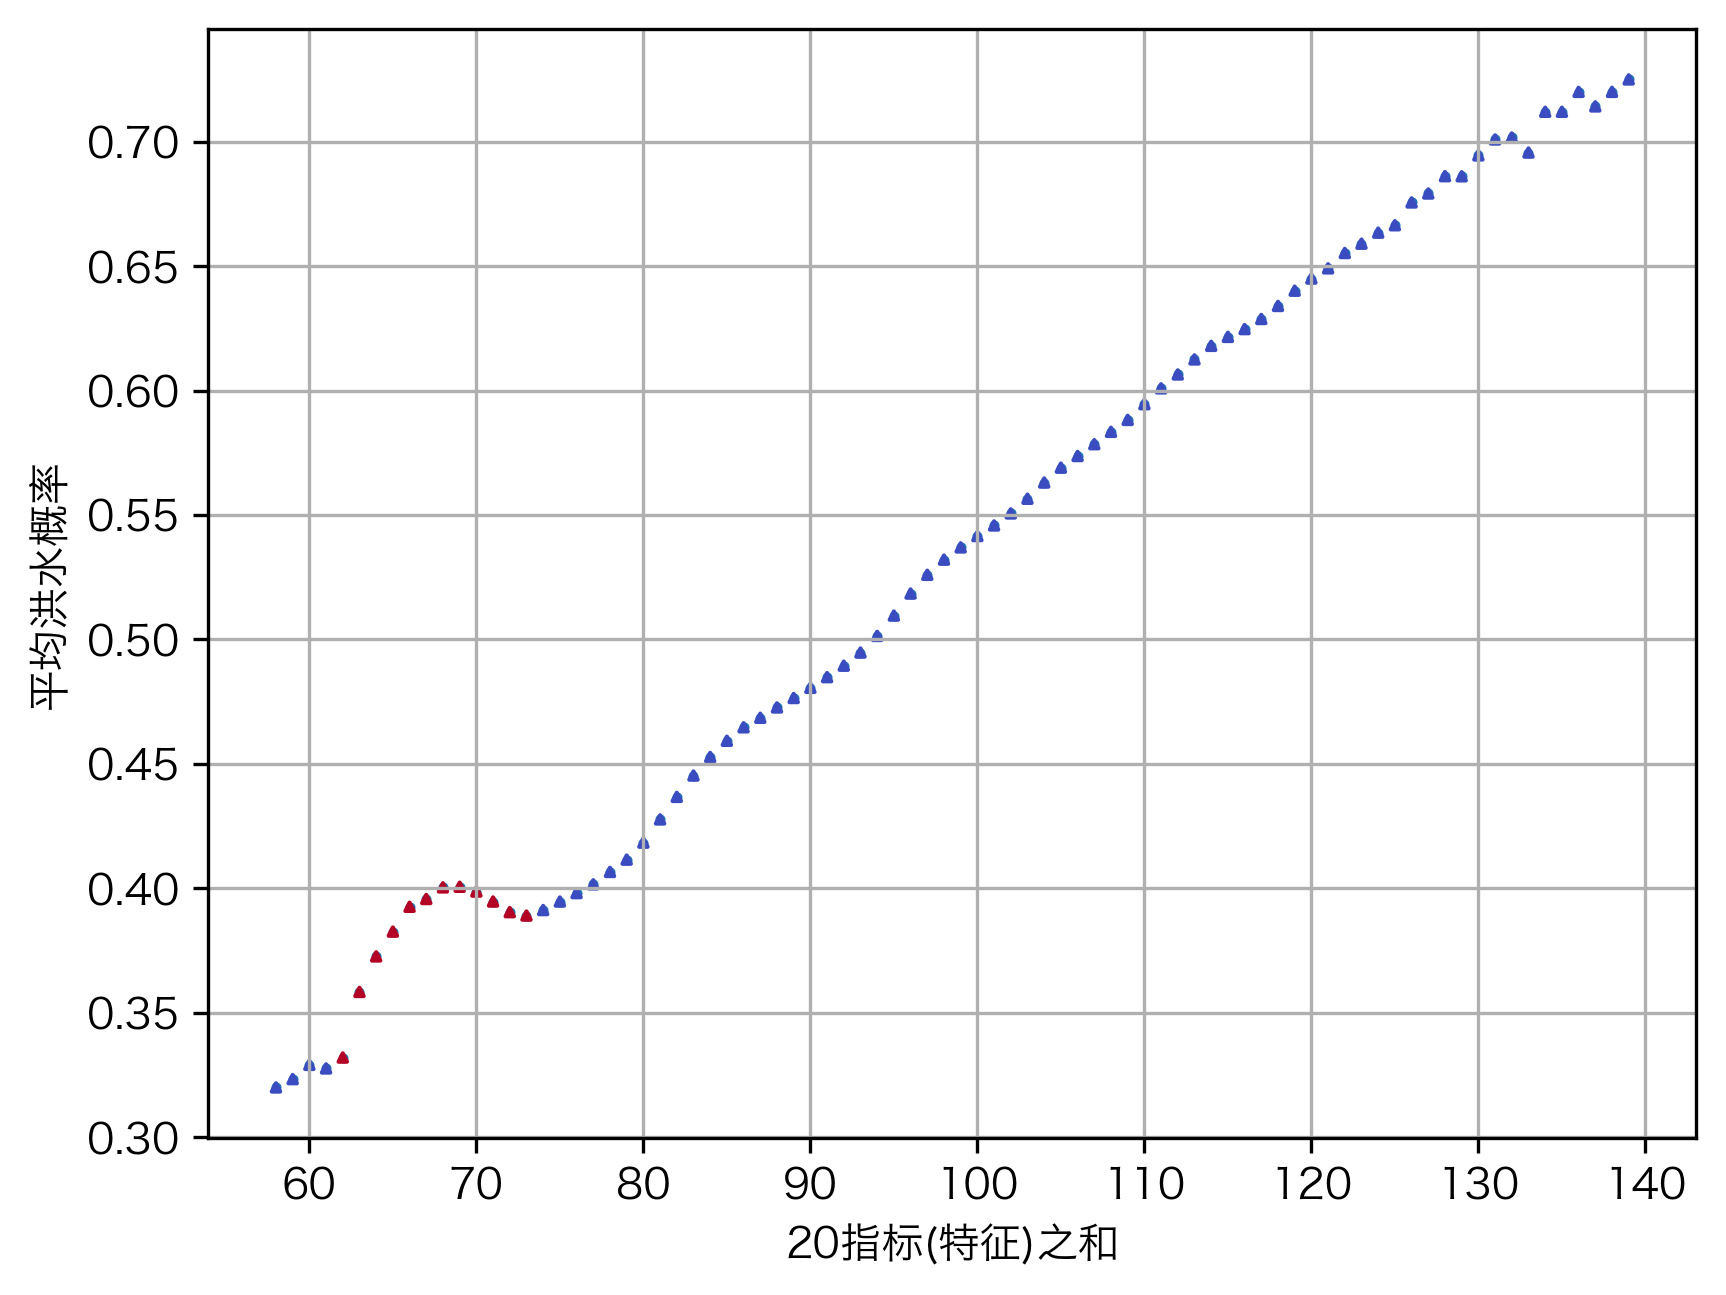

In [161]:
temp = train.洪水概率.groupby(train[initial_features].sum(axis=1)).mean()
plt.figure(dpi=300)
plt.scatter(temp.index, temp, marker='o', s=2, cmap='PuBuGn')
plt.scatter(temp.index, temp, marker='^',
            s=4, c=(temp.index.isin(np.arange(62, 74))),
            cmap='coolwarm', )
plt.xlabel('20指标(特征)之和')
plt.ylabel('平均洪水概率')
plt.grid()
plt.show()

可以观察到，洪水发生概率与特征之和基本呈正相关，同时，观察到线性关系中存在特殊值，因此，我们将两者都纳入模型考虑范围

In [162]:
for df in [train, test]:
    df['指标和'] = df[initial_features].sum(axis=1) 
    df['特殊点'] = df['指标和'].isin(np.arange(62, 74)) 

In [163]:
train.head()

,季风强度,地形排水,河流管理,森林砍伐,城市化,气候变化,大坝质量,淤积,农业实践,侵蚀,...,流域,基础设施恶化,人口得分,湿地损失,规划不足,政策因素,洪水概率,聚类,指标和,特殊点
id,,,,,,,,,,,,,,,,,,,,,
0,5,8,5,8,6,4,4,3,3,4,...,5,4,7,5,7,3,0.445,0,91,False
1,6,7,4,4,8,8,3,5,4,6,...,3,5,3,3,4,3,0.450,0,91,False
2,6,5,6,7,3,7,1,5,4,5,...,5,6,8,2,3,3,0.530,1,96,False
3,3,4,6,5,4,8,4,7,6,8,...,4,4,6,5,7,5,0.535,1,99,False
4,5,3,2,6,4,4,3,3,3,3,...,6,4,1,2,3,5,0.415,0,67,True


In [164]:
# model = catboost.CatBoostRegressor(verbose=False)
# cross_validate(model, 'CatBoost fsum', features=initial_features+['指标和'])
# # Overall: 0.86840 CatBoost single fold   2 min

将指标进行从小到大排序

In [165]:
sorted_features = [f"指标排序{i}" for i in np.arange(len(initial_features))]
for df in [train, test]:
    df[sorted_features] = np.sort(df[initial_features], axis=1)
train.head()

,季风强度,地形排水,河流管理,森林砍伐,城市化,气候变化,大坝质量,淤积,农业实践,侵蚀,...,指标排序9,指标排序10,指标排序11,指标排序12,指标排序13,指标排序14,指标排序15,指标排序16,指标排序17,指标排序18
id,,,,,,,,,,,,,,,,,,,,,
0,5,8,5,8,6,4,4,3,3,4,...,5,5,5,5,5,6,7,7,8,8
1,6,7,4,4,8,8,3,5,4,6,...,4,5,5,6,6,7,7,8,8,9
2,6,5,6,7,3,7,1,5,4,5,...,5,6,6,6,6,7,7,7,7,8
3,3,4,6,5,4,8,4,7,6,8,...,5,5,6,6,6,7,7,7,8,8
4,5,3,2,6,4,4,3,3,3,3,...,3,3,4,4,4,5,5,6,6,6


In [166]:
# model = catboost.CatBoostRegressor(verbose=False)
# cross_validate(model, 'CatBoost sorted', features=sorted_features+['指标和'])

In [167]:
for df in [train, test]:
    df['中位数'] = np.median(df[initial_features], axis=1)
    df['标准差'] = np.std(df[initial_features], axis=1)
    df['平均数'] = np.mean(df[initial_features], axis=1)

In [168]:
import itertools

extra_features = [
    '中位数', 
    '标准差', 
    '平均数', 
]

power_set = list(itertools.chain(
    *[itertools.combinations(extra_features, r) 
      for r in range(len(extra_features) + 1)]))

power_set_as_lists = [list(subset) for subset in power_set]

print(power_set_as_lists)

[[], ['中位数'], ['标准差'], ['平均数'], ['中位数', '标准差'], ['中位数', '平均数'], ['标准差', '平均数'], ['中位数', '标准差', '平均数']]


构造幂集进行多方测试

In [169]:
# for idx, ef in enumerate(power_set_as_lists):
#     print(idx + 1, ef)
#     model = catboost.CatBoostRegressor(verbose=False)
#     cross_validate(model, 'CatBoost extra', features=sorted_features+['指标和']+ef)

# 1 []
# # Fold 0: R2=0.80326, acc_3=0.73407
# # Overall: 0.80326 CatBoost extra single fold   1 min
# 2 ['中位数']
# # Fold 0: R2=0.80322, acc_3=0.73376
# # Overall: 0.80322 CatBoost extra single fold   1 min
# 3 ['标准差']
# # Fold 0: R2=0.80317, acc_3=0.73381
# # Overall: 0.80317 CatBoost extra single fold   1 min
# 4 ['平均数']
# # Fold 0: R2=0.80323, acc_3=0.73409
# # Overall: 0.80323 CatBoost extra single fold   1 min
# 5 ['中位数', '标准差']
# # Fold 0: R2=0.80317, acc_3=0.73387
# # Overall: 0.80317 CatBoost extra single fold   1 min
# 6 ['中位数', '平均数']
# # Fold 0: R2=0.80324, acc_3=0.73437
# # Overall: 0.80324 CatBoost extra single fold   1 min
# 7 ['标准差', '平均数']
# # Fold 0: R2=0.80323, acc_3=0.73420
# # Overall: 0.80323 CatBoost extra single fold   1 min
# 8 ['中位数', '标准差', '平均数']
# # Fold 0: R2=0.80320, acc_3=0.73423
# # Overall: 0.80320 CatBoost extra single fold   1 min

1 []
# Fold 0: R2=0.80326, acc_3=0.73407
# Overall: 0.80326 CatBoost extra single fold   1 min
2 ['中位数']
# Fold 0: R2=0.80322, acc_3=0.73376
# Overall: 0.80322 CatBoost extra single fold   1 min
3 ['标准差']
# Fold 0: R2=0.80317, acc_3=0.73381
# Overall: 0.80317 CatBoost extra single fold   1 min
4 ['平均数']
# Fold 0: R2=0.80323, acc_3=0.73409
# Overall: 0.80323 CatBoost extra single fold   1 min
5 ['中位数', '标准差']
# Fold 0: R2=0.80317, acc_3=0.73387
# Overall: 0.80317 CatBoost extra single fold   1 min
6 ['中位数', '平均数']
# Fold 0: R2=0.80324, acc_3=0.73437
# Overall: 0.80324 CatBoost extra single fold   1 min
7 ['标准差', '平均数']
# Fold 0: R2=0.80323, acc_3=0.73420
# Overall: 0.80323 CatBoost extra single fold   1 min
8 ['中位数', '标准差', '平均数']
# Fold 0: R2=0.80320, acc_3=0.73423
# Overall: 0.80320 CatBoost extra single fold   1 min


发现最优情况是不加入额外特征

In [203]:
best = catboost.CatBoostRegressor(
    verbose=False,
)
best_model = cross_validate(
    best, 
    'CatBoost_FeartureSum_Sorted', 
    features=sorted_features+['指标和'],
    n_repeats=4
)

# Fold 0: R2=0.80327, acc_3=0.73389
# Overall: 0.80327 CatBoost_FeartureSum_Sorted single fold   2 min


In [199]:
result_df = pd.read_csv(join(data_root, 'submit.csv'), index_col=0)
result_df.head()

,洪水概率,Unnamed: 2,Unnamed: 3
id,,,
1117957,0.5,NaN,NaN
1117958,0.5,NaN,
1117959,0.5,NaN,NaN
1117960,0.5,NaN,NaN
1117961,0.5,NaN,NaN


In [200]:
if COMPUTE_TEST_PRED:
    result_df['洪水概率'] = test_pred['CatBoost_FeartureSum_Sorted']
result_df.head(10)

,洪水概率,Unnamed: 2,Unnamed: 3
id,,,
1117957,0.575508,NaN,NaN
1117958,0.469211,NaN,
1117959,0.469468,NaN,NaN
1117960,0.471547,NaN,NaN
1117961,0.467971,NaN,NaN
1117962,0.495009,NaN,NaN
1117963,0.538069,NaN,NaN
1117964,0.536228,NaN,NaN
1117965,0.483851,NaN,NaN


In [201]:
filename = 'submit.csv'
result_df.to_csv(filename)
os.system(f"head {filename}")

id,洪水概率,Unnamed: 2,Unnamed: 3
1117957,0.575507986436576,,
1117958,0.46921128902382947,, 
1117959,0.46946826473651976,,
1117960,0.47154700382475223,,
1117961,0.46797063685559903,,
1117962,0.495009332102001,,
1117963,0.538068888890392,,
1117964,0.5362278106402385,,
1117965,0.4838512291384691,,


0

In [204]:
from joblib import load

name = 'CatBoost_FeartureSum_Sorted_0_3.joblib'
weight_path = join(weight_dir, name)
model = load(weight_path)

In [225]:
model.feature_importances_, model.feature_names_

(array([2.07535270e-01, 2.05930960e-01, 4.86728495e-01, 8.85430849e-02,
        8.06271469e-02, 8.75455293e-02, 9.53833582e-02, 7.38149177e-02,
        8.38060813e-02, 9.32353166e-02, 9.26230142e-02, 8.84711513e-02,
        8.34919874e-02, 7.29353782e-02, 1.03576402e-01, 1.01118551e-01,
        1.45936220e-01, 2.01065896e-01, 1.58751778e+00, 9.60201135e+01]),
 ['指标排序0',
  '指标排序1',
  '指标排序2',
  '指标排序3',
  '指标排序4',
  '指标排序5',
  '指标排序6',
  '指标排序7',
  '指标排序8',
  '指标排序9',
  '指标排序10',
  '指标排序11',
  '指标排序12',
  '指标排序13',
  '指标排序14',
  '指标排序15',
  '指标排序16',
  '指标排序17',
  '指标排序18',
  '指标和'])

In [233]:
model.best_score_

{'learn': {'RMSE': 0.022606382572071416}}